# Install required modules and Download the data

In [1]:
!nvidia-smi

Mon Mar  9 03:39:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip -qq install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
!pip -qq install torch-geometric

     |████████████████████████████████| 10.6MB 326kB/s 
     |████████████████████████████████| 11.5MB 377kB/s 
     |████████████████████████████████| 143kB 4.8MB/s 
     |████████████████████████████████| 348kB 11.2MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 


Torchvision like format - <br>a directory graph with <br>sub-direcotry "raw" to store raw files and <br>sub-direcotry "processsed" to store individual graph in .pt format

In [1]:
!mkdir /content/graphs
!mkdir /content/graphs/raw
!mkdir /content/graphs/processed
%cd /content/graphs/raw
!wget -qq "https://zenodo.org/record/3164691/files/QG_jets.npz"

###### Uncomment commands given below to train on entire dataset ########

# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_1.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_2.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_3.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_4.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_5.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_6.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_7.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_8.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_9.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_10.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_11.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_12.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_13.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_14.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_15.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_16.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_17.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_18.npz"
# !wget -qq "https://zenodo.org/record/3164691/files/QG_jets_19.npz"

%cd /content

mkdir: cannot create directory ‘/content/graphs’: File exists
mkdir: cannot create directory ‘/content/graphs/raw’: File exists
mkdir: cannot create directory ‘/content/graphs/processed’: File exists
/content/graphs/raw
/content


# DataGenerator and Pre-processing

In [0]:
import os.path as osp
from tqdm import tqdm
import seaborn as sns

import numpy as np
import torch
from torch_geometric.data import Dataset, Data, DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import glob

A OneHot encoder for particle ids and standard scaler to standarize data



In [5]:
L = [-2212.0, -2112.0, -321.0, -211.0, -13.0, -11.0, 0.0, 11.0, 13.0, 22.0, 130.0, 211.0, 321.0, 2112.0, 2212.0]

########## OneHot encoder #####################

enc = OneHotEncoder()
enc.fit(np.array(L).reshape(-1,1))
# print(enc.categories_)

########## Standards scaler ######################3

for file in [glob.glob("/content/graphs/raw/*.npz")[0]]:
  f = []                                                                  ##### List to store graphs after removing appended rows with zero enteries 
  X_ = np.load(file)['X']
  for i_ in tqdm(range(len(X_))):
      X = X_[i_]
      for j_ in range(len(X)-1,-1,-1):                                    ##### j_ is the finds the last row from the back with all zero enteries
        if np.sum(X[j_])!=0:
          break
      f.append(X[:j_+1])                                                  ##### Add graph to the list 
  scaler = StandardScaler()
  f = np.concatenate(f)                                                   ##### Concatenate graphs to fit standard sclaer
  # print(f.shape)
  f = f[:,:3].reshape(-1,3)
  scaler.fit(f)
  print("Mean along various feature axis",scaler.mean_)
  print("Variance along various feature axis",scaler.var_)

100%|██████████| 100000/100000 [00:39<00:00, 2515.31it/s]


Mean along various feature axis [1.20958133e+01 2.71643237e-03 3.13742929e+00]
Variance along various feature axis [610.8069783    0.7709161    3.31537096]


Visualize distribution of features

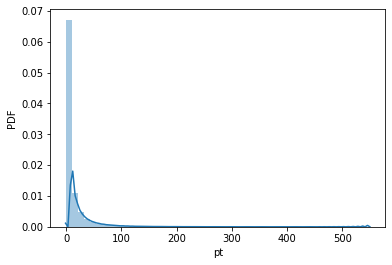

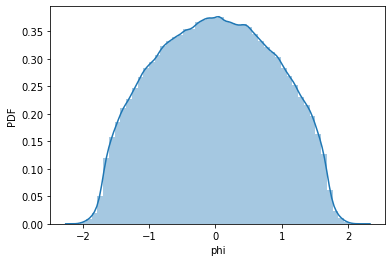

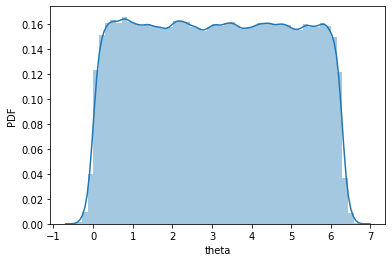

In [6]:
import matplotlib.pyplot as plt

labels = ['pt', 'phi', 'theta']
for i in range(3):
  sns.distplot(f[:,i])
  plt.ylabel("PDF")
  plt.xlabel(labels[i])
  plt.show()

**DataLoader - JetDatset**

Methods - <br>
raw_file_names : Returns list with name of the files in raw folder<br>
processed_file_names : Returns list with name of the files in processed folder<br>
Process : Extraxt graph from raw files -> Removes rows with all zero entry -> Save graph in .pt format<br>
len : Return total number of processed graphs<br>
get : Standarize features and onehot encode particle ids 

In [0]:
class JetDataset(Dataset):
    def __init__(self, root = '/content/graphs', transform=None, pre_transform=None):
        super(JetDataset, self).__init__(root, transform, pre_transform)
        if len(glob.glob("/content/graphs/processed/*.pt"))<5:            ##### Use method Process only if processed directory is empty
            self.process()

    @property
    def raw_file_names(self):                                             ##### Returns list with name of the files in raw folder
        return glob.glob("/content/graphs/raw/*.npz")

    @property
    def processed_file_names(self):                                       ##### Returns list with name of the files in processed folder
        return glob.glob("/content/graphs/processed/*.pt")

    def process(self):
        count = 0
        for file in self.raw_paths:
            print("Processing :", file)
            X_ = np.load(file)['X']
            Y_ = np.load(file)['y']
            
            for i_ in tqdm(range(len(X_))):
              X = X_[i_]
              for j_ in range(len(X)-1,-1,-1):
                if np.sum(X[j_])!=0:
                  break
              y = [Y_[j_]]
              I = []
              O = []
              X = X[:j_+1,:]
              for i in range(len(X)):
                for j in range(len(X)):
                  if i!=j:
                    I.append(i)
                    O.append(j)
              X = torch.tensor(X, dtype=torch.float)
              y = torch.tensor(y, dtype=torch.float)
              edge_index = torch.tensor([I, O], dtype=torch.long)
              data = Data(x = X, y = y, edge_index=edge_index)

              if self.pre_filter is not None and not self.pre_filter(data):
                continue

              if self.pre_transform is not None:
                data = self.pre_transform(data)

              torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(count)))
              count += 1

    def len(self):                                                       ###### Returns total number of processed graph in processed directory
        return len(self.processed_file_names)

    def get(self, idx):
        data1 = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(idx)))
        p1 = enc.transform(data1.x[:,3].reshape(-1,1)).toarray()
        p2 = scaler.transform(data1.x[:,:3])
        data = Data(x=torch.cat([torch.tensor(p2, dtype=torch.float),torch.tensor(p1, dtype=torch.float)],axis=1) , y=data1.y, edge_index=data1.edge_index)
        return data

In [0]:
dataset = JetDataset()                                                   ###### Object of Dataloader

# Model architectures

In [0]:
import torch
from torch.nn import Sequential as Seq, Linear, ReLU, Tanh, Sigmoid, BCELoss
from torch_geometric.nn import MessagePassing, global_mean_pool, SAGPooling, TopKPooling, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
from torch_geometric.utils import dropout_adj

import warnings
warnings.filterwarnings("ignore")

Custom **Message Passing Layer (MPL)** -<br><br>
Message : Concatenate representations of two nodes and paas them through a neural network to get a representation of edge between them --> Concatenate two nodes and edge representation and paas them through the neural network to get required message<br><br>
Update : Add all the messages to a node --> Concatenate with node representation --> paas through neural network to get updated node representation 

Reference - [Isaac Henrion, Johann Brehmer, Joan Bruna, Kyunghun Cho, Kyle Cranmer. Neural Message Passing for Jet Physics](https://dl4physicalsciences.github.io/files/nips_dlps_2017_29.pdf)

In [0]:
class MPL(MessagePassing):
    def __init__(self):
        super(MPL, self).__init__(aggr='max') #  "Max" aggregation.
        self.mlp1 = Seq(Linear(128, 64), Tanh())
        self.mlp2 = Seq(Linear(64*3, 64), ReLU())
        self.mlp3 = Seq(Linear(128, 64), ReLU())

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_i, x_j):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]

        a_ij = self.mlp1(torch.cat([x_i, x_j], dim=1))
        tmp = self.mlp2(torch.cat([x_i, x_j,a_ij], dim=1))

        return tmp

    def update(self, aggr_out,x):
        # aggr_out has shape [N, out_channels]
        r = self.mlp3(torch.cat([x,aggr_out], dim=1))
        r = x+r

        return r

<h2>Model

**Architecture Sequence -** <br><br>
SAGEconvolution<br>
Custom MPL<br>
Skip Connection<br>
Custom MPL<br>
SAGE Convolution<br>
TopKPooling<br>
Concat ( global_mean_pool, global_max_pool ) - embedding 1<br>
SAGE Convolution<br>
Skip Connection<br>
TopKPooling<br>
Concat ( global_mean_pool, global_max_pool ) - embedding 2<br>
SAGE Convolution<br>
Skip Connection<br>
TopKPooling<br>
Concat ( global_mean_pool, global_max_pool ) - embedding 3<br>
SAGE Convolution<br>
Add all three graph embeddings<br>
Dropout<br>
Linear - Relu activation<br>
Dropout<br>
Linear - Relu activation<br>
Dropout<br>
Sigmoid


In [0]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = SAGEConv(18, 64)
        self.conv1_ = MPL()
        self.pool1 = TopKPooling(128, ratio=0.8)
        # self.pool1 = SAGPooling(128, ratio=0.8)
        self.conv2 = SAGEConv(128, 128)
        self.conv2_ = MPL()
        self.pool2 = TopKPooling(128, ratio=0.8)
        # self.pool2 = SAGPooling(128, ratio=0.8)
        self.conv3 = SAGEConv(128, 128)
        self.conv3_ = MPL()
        self.pool3 = TopKPooling(128, ratio=0.8)
        # self.pool3 = SAGPooling(128, ratio=0.8)
        self.conv4 = SAGEConv(128, 128)
        self.conv5 = SAGEConv(64, 128)
        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch  

        x_0 = F.relu(self.conv1(x, edge_index))
        x_1 = self.conv1_(x_0, edge_index)
        x_2 = self.conv2_(x_1, edge_index)

        # x_2 = F.relu(self.conv4(x_1, edge_index))
        x_2 = x_2 + x_1
        x = F.relu(self.conv5(x_2, edge_index))
        # x = x_3 + x_2

        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x_ = F.relu(self.conv2(x, edge_index))
        x = x + x_

        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x_ = F.relu(self.conv3(x, edge_index))
        x = x + x_

        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.dropout(x, p=0.5, training=self.training)  
        x = self.lin1(x)
        x = self.act1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.3, training=self.training)

        x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x

# Train, Evaluate, Save and Reload

In [0]:
num_epochs = 10                                                           ##### max number of epochs
batch_size=512
PATH = '/content/model.pt'                                                ##### Path to save model

<h2>Tain, Val and Test Generators

In [0]:
dataset.shuffle()                                                         ##### Shuffle dataset

train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset = dataset[int(len(dataset)*0.9):]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [0]:
## Number of samples in train, val and test
print(len(train_dataset), len(val_dataset), len(test_dataset))

**Evaluate function**

In [0]:
from sklearn.metrics import roc_auc_score

def evaluate(loader):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in tqdm(loader):

            data = data.to(device)
            pred = model(data).detach().cpu().numpy().flatten()

            label = data.y.detach().cpu().numpy().flatten()
            predictions.append(pred)
            labels.append(label)

    labels = np.concatenate(labels)
    predictions = np.concatenate(predictions)
    print(labels.shape,predictions.shape)
    return (roc_auc_score(labels, predictions))

**Shift model to GPU**

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1)
bce = BCELoss()

**Train**

In [16]:
count = 0
for epoch in range(num_epochs):
    model.train()
    loss_all = 0
    for data in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        # label = data.y.view(-1, 1).to(device)
        loss = bce(output, label)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    print('\n',"Epoch :", epoch+1)
    print("Training loss :",loss_all/len(train_dataset))
    val_auc = evaluate(val_loader)
    lr_scheduler.step(-val_auc)
    print("Val AUC :",val_auc)
    count = count+1
print("Test_AUC :",evaluate(test_loader))

  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch : 1
Training loss : 0.6825026425361633


  0%|          | 0/157 [00:00<?, ?it/s]

(10000,) (10000,)
Val AUC : 0.5880884179721991


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch : 2
Training loss : 0.6663196027755738


  0%|          | 0/157 [00:00<?, ?it/s]

(10000,) (10000,)
Val AUC : 0.6256328565301849


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch : 3
Training loss : 0.6612690538406372


  0%|          | 0/157 [00:00<?, ?it/s]

(10000,) (10000,)
Val AUC : 0.6589733343424405


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch : 4
Training loss : 0.6429256559371949


  0%|          | 0/157 [00:00<?, ?it/s]

(10000,) (10000,)
Val AUC : 0.690530840838568


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch : 5
Training loss : 0.6255416944503784


  0%|          | 0/157 [00:00<?, ?it/s]

(10000,) (10000,)
Val AUC : 0.7126584828073361


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch : 6
Training loss : 0.6144924646377563


  0%|          | 0/157 [00:00<?, ?it/s]

(10000,) (10000,)
Val AUC : 0.7113879563056585


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch : 7
Training loss : 0.6108616555213928


  0%|          | 0/157 [00:00<?, ?it/s]

(10000,) (10000,)
Epoch     7: reducing learning rate of group 0 to 5.0000e-04.
Val AUC : 0.7102830041121118


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch : 8
Training loss : 0.5961282676696777


  0%|          | 0/157 [00:00<?, ?it/s]

(10000,) (10000,)
Val AUC : 0.7176930598652842


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch : 9
Training loss : 0.5933657427787781


  0%|          | 0/157 [00:00<?, ?it/s]

(10000,) (10000,)
Val AUC : 0.7172586795832387


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch : 10
Training loss : 0.5924006509780884


  0%|          | 0/20 [00:00<?, ?it/s]

(10000,) (10000,)
Val AUC : 0.718388960367315


100%|██████████| 20/20 [00:15<00:00,  1.49it/s]

(10000,) (10000,)
Test_AUC : 0.7237268098987539


**Save and Reload**

In [22]:
torch.save(model.state_dict(), PATH)
model = Net()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>